In [1]:
# Reload magic
%reload_ext autoreload
%autoreload 2

In [2]:
# Ignore user warnings
import warnings

import cellrank as cr
import jax
import matplotlib.pyplot as plt
import numpy as np
import optax
import orbax
import scanpy as sc
from flax.linen.activation import gelu
from tqdm import tqdm

import spacetime
from spacetime import potentials, steps

warnings.filterwarnings("ignore")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Load data

In [3]:
adata = sc.read_h5ad(
    "/export/home1/users/csb/huizing/Documents/PhD/Data/zesta/spatial_sixtime_slice_stereoseq_processed.h5ad"
)
adata

AnnData object with n_obs × n_vars = 13165 × 10000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'time', 'n_genes'
    var: 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'pearson_residuals_normalization', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'scale.data'
    obsp: 'connectivities', 'distances'

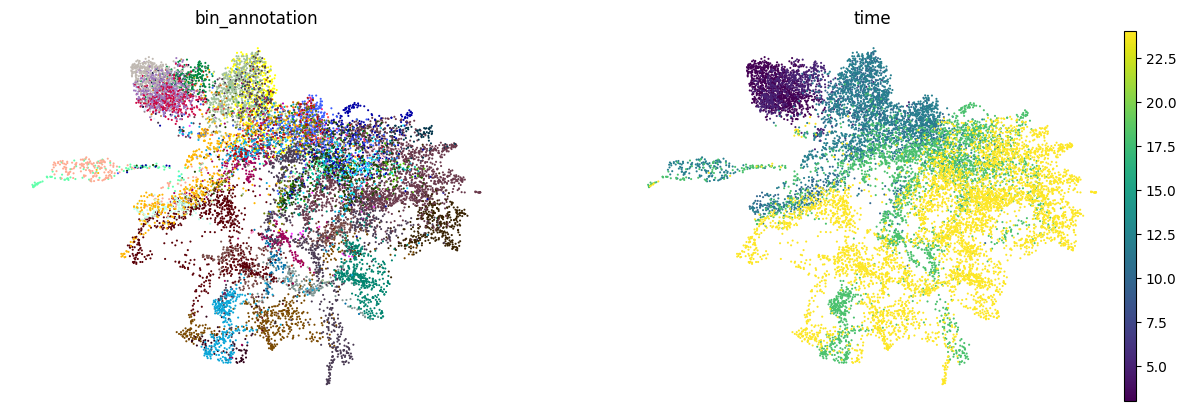

In [8]:
sc.pl.umap(adata, color=["bin_annotation", "time"], frameon=False, legend_loc="none")

In [5]:
for t in adata.obs["time"].unique():
    idx = adata.obs["time"] == t
    print(t, len(adata[idx]))

24 5271
18 3048
12 2081
10 1036
5 562
3 1167


In [34]:
adata.obsm["X_pca_harmony"] = adata.obsm["X_pca_harmony"][:, :20]
adata.obsm["X_pca_harmony"] /= adata.obsm["X_pca_harmony"].max()

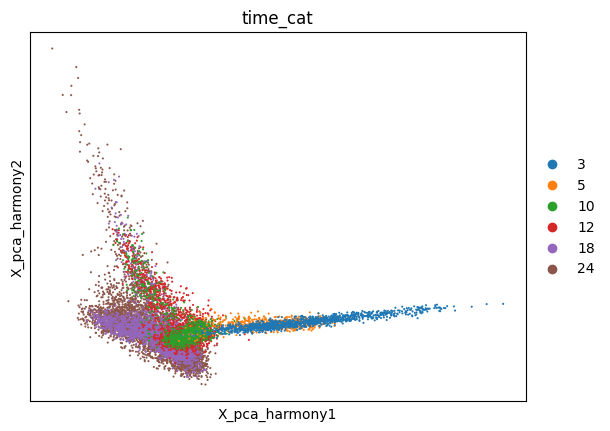

In [35]:
adata.obs["time_cat"] = adata.obs["time"].copy()
adata.obs["time_cat"] = adata.obs["time_cat"].astype("category")
sc.pl.embedding(adata, basis="X_pca_harmony", color="time_cat")

## Train model

In [36]:
# Define the potential.
potential = potentials.MLPPotential(features=[64, 64], activation=gelu)

# Define the proximal step.
proximal_step = steps.LinearExplicitStep()

# Define the model.
model = spacetime.SpaceTime(
    potential=potential,
    proximal_step=proximal_step,
    tau_auto=True,
    epsilon=0.01,
)

In [37]:
!rm -r /tmp/zesta

In [38]:
# Define the checkpoint manager.
options = orbax.checkpoint.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    best_fn=lambda x: x["loss"],
    best_mode="min",
)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    "/tmp/zesta/checkpoints",
    orbax.checkpoint.PyTreeCheckpointer(),
    options=options,
)
for step in checkpoint_manager.all_steps():
    checkpoint_manager.delete(step)

# Fit the model.
model.fit(
    adata[adata.obs["time"] < adata.obs["time"].max()],  # Without the last timepoint.
    time_obs="time",
    x_obsm="X_pca_harmony",
    space_obsm="spatial",
    batch_size=250,
    patience=100,
    optimizer=optax.adamw(1e-2),
    min_delta=1e-4,
    checkpoint_manager=checkpoint_manager,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Train (# cells):  [933, 449, 828, 1664, 2438]
Val (# cells):  [234, 113, 208, 417, 610]


  8%|▊         | 818/10000 [01:32<19:11,  7.98it/s, iteration=818, train_loss=0.008465716, val_loss=0.004802686]  

In [ ]:
best_step = checkpoint_manager.best_step()
print("Restoring best step:", best_step)
model.params = checkpoint_manager.restore(best_step)
potential_fn = lambda x: model.potential.apply(model.params, x)
adata.obs["potential"] = np.array(jax.vmap(potential_fn)(adata.obsm["X_pca_harmony"]))

Restoring best step: 891


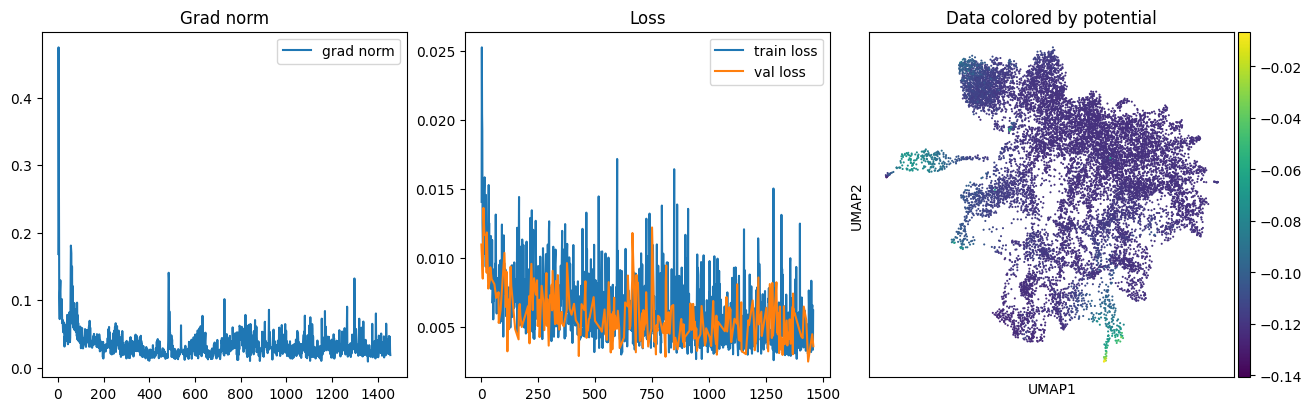

In [ ]:
# Plot the data, with a legend for the timepoints, color with Reds.
fig, axes = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

axes[0].plot(model.train_it, model.grad_norms, label="grad norm")
axes[0].set_title("Grad norm")
axes[0].legend()

axes[1].plot(model.train_it, model.train_losses, label="train loss")
axes[1].plot(model.val_it, model.val_losses, label="val loss")
axes[1].set_title("Loss")
axes[1].legend()

# Plot the data colored by potential
sc.pl.umap(adata, color="potential", ax=axes[2], show=False)
# Legend with larger dots.
axes[2].set_title("Data colored by potential")
plt.show()

## Display the predictions

In [ ]:
adata.obsm["X_pred"] = adata.obsm["X_pca_harmony"].copy()
adata.obs["time"] = adata.obs["time"].astype(int)

# Get difference between consecutive points of t
t_diff = np.diff(np.sort(adata.obs["time"].unique())).astype(float)
t_diff /= t_diff[-1]
t_diff = np.concatenate([t_diff, [1.0]])

for i, t in tqdm(enumerate(np.unique(adata.obs["time"]))):
    idx = adata.obs["time"] == t
    adata.obsm["X_pred"][idx] = model.transform(
        adata[idx],
        time_obs="time",
        x_obsm="X_pca_harmony",
        batch_size=500,
        tau=t_diff[i],
    )

6it [00:01,  5.37it/s]


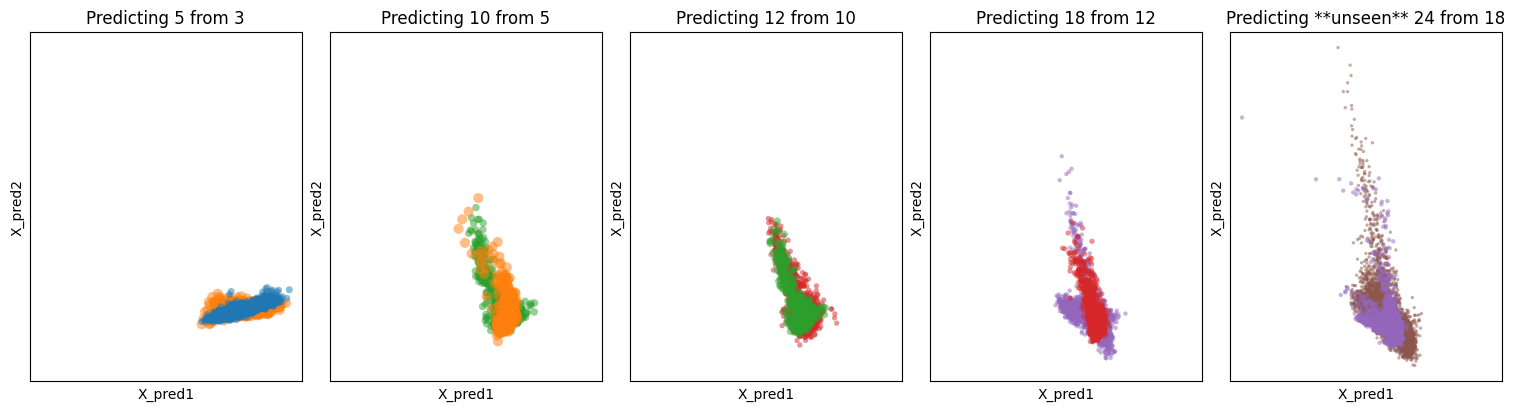

In [ ]:
timepoints = np.sort(adata.obs["time"].unique())
fig, axes = plt.subplots(
    1,
    len(timepoints) - 1,
    figsize=(15, 4),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
for i in range(len(timepoints) - 1):
    sc.pl.embedding(
        adata[adata.obs["time"] == timepoints[i + 1]],
        basis="X_pca_harmony",
        color="time_cat",
        ax=axes[i],
        alpha=0.5,
        show=False,
        legend_loc="upper right",
    )
    sc.pl.embedding(
        adata[adata.obs["time"] == timepoints[i]],
        basis="X_pred",
        color="time_cat",
        ax=axes[i],
        alpha=0.5,
        show=False,
        legend_loc="upper right",
    )
    axes[i].set_title(f"Predicting {timepoints[i+1]} from {timepoints[i]}")
axes[i].set_title(f"Predicting **unseen** {timepoints[i+1]} from {timepoints[i]}")
plt.show()

In [ ]:
from scipy.spatial.distance import cdist
from scipy.special import softmax

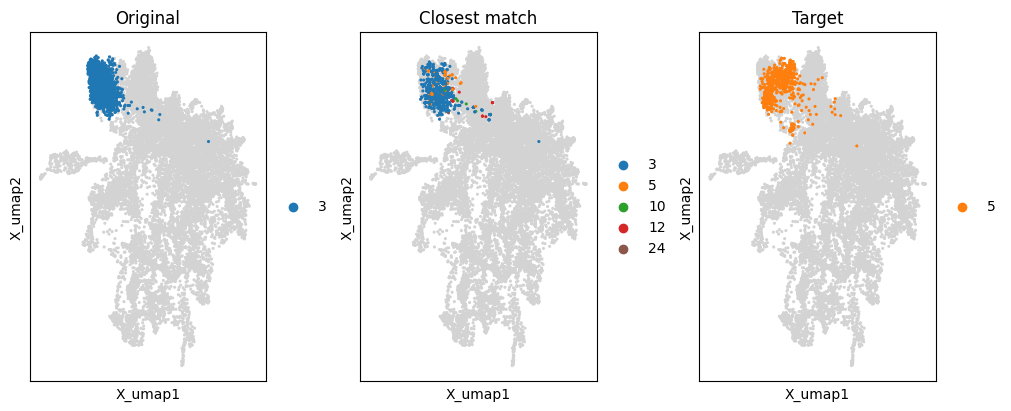

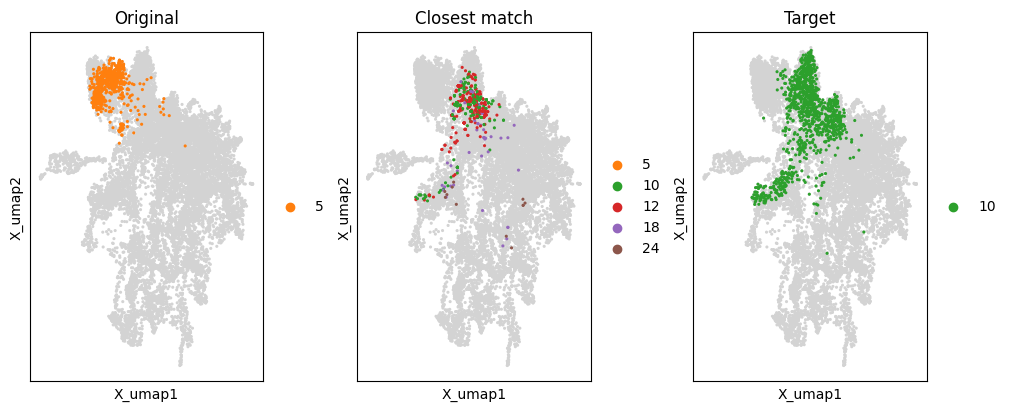

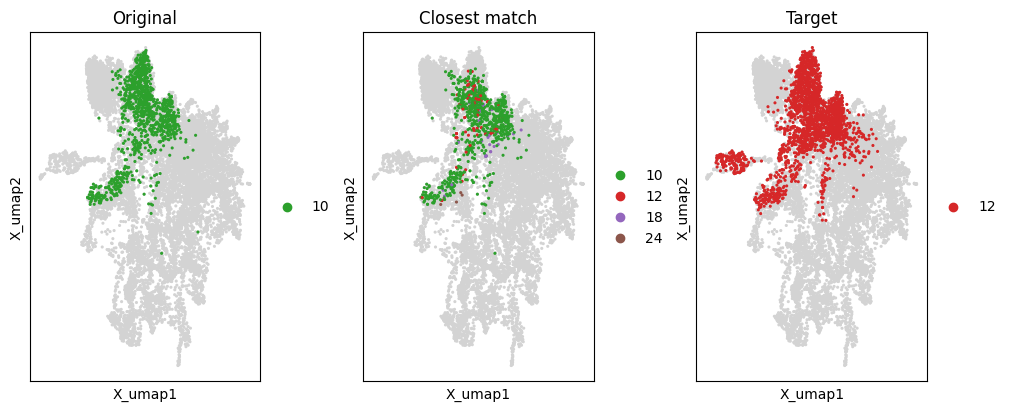

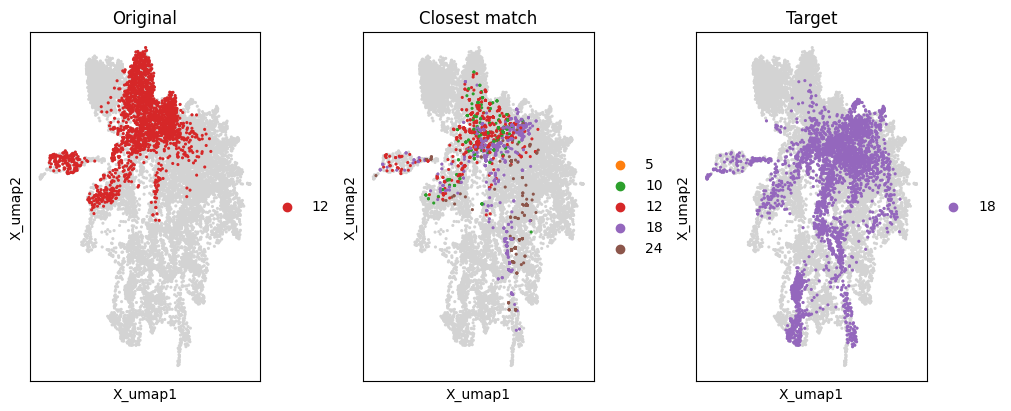

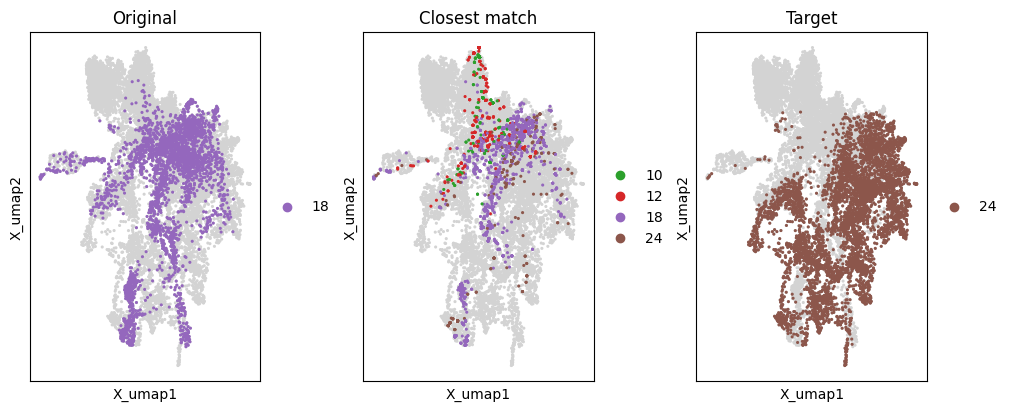

In [ ]:
for i, t in enumerate(timepoints[:-1]):
    idx_left = adata.obs["time"] == t
    D = cdist(adata.obsm["X_pred"][idx_left], adata.obsm["X_pca_harmony"])
    idx_right = D.argmin(1)
    idx_target = adata.obs["time"] == timepoints[i + 1]
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
    sc.pl.embedding(adata, basis="X_umap", s=20, ax=axes[0], show=False)
    sc.pl.embedding(
        adata[idx_left], basis="X_umap", s=20, ax=axes[0], color="time_cat", show=False
    )
    sc.pl.embedding(adata, basis="X_umap", s=20, ax=axes[1], show=False)
    sc.pl.embedding(
        adata[idx_right], basis="X_umap", s=20, ax=axes[1], color="time_cat", show=False
    )
    sc.pl.embedding(adata, basis="X_umap", s=20, ax=axes[2], show=False)
    sc.pl.embedding(
        adata[idx_target],
        basis="X_umap",
        s=20,
        ax=axes[2],
        color="time_cat",
        show=False,
    )
    axes[0].set_title("Original")
    axes[1].set_title("Closest match")
    axes[2].set_title("Target")
    plt.show()

## Display velocity

  0%|          | 0/13165 [00:00<?, ?cell/s]

  0%|          | 0/13165 [00:00<?, ?cell/s]

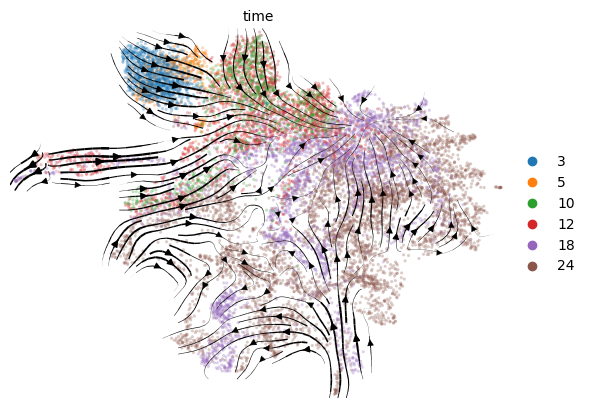

In [ ]:
adata.obsm["X_velocity"] = adata.obsm["X_pred"] - adata.obsm["X_pca_harmony"]
vk = cr.kernels.VelocityKernel(
    adata, xkey="X_pca_harmony", vkey="X_velocity", attr="obsm"
)
vk.compute_transition_matrix()
vk.plot_projection(basis="umap", recompute=True, color="time", legend_loc="right", s=20)